In [5]:
from nltk.lm.preprocessing import pad_both_ends
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from cosine_cost import CosineCost, plot_breakpoints
from discourse import plot_discourse, glyph_bound
from horley_encoding import convert_to_horley

import numpy as np

In [77]:
# Read and preprocess data

with open('data/I.csv', 'r') as file:
    raw_data_I = [line.split(',')[1][:-1] for line in file.readlines()]

# We remove glyph 999 (separator)
clean_lines_I = [line.replace('999', '').split('-') for line in raw_data_I]
encoded_lines_I = [[convert_to_horley(glyph) for glyph in line] for line in clean_lines_I]

In [78]:
# Automatic extraction of the triads by splitting
# whenever we find glyph 076 as an appendage

sequences_I = []

for line in encoded_lines_I:
    i = 0
    j = 1
    while j < len(line):
        if line[j][-3:] == '.76':
            sequences_I.append(line[i:j])
            i = j
        j += 1

# We will add a special token to represent glyph 076
# when appended to the first glyph of the triad

for i in range(len(sequences_I)):
    sequences_I[i][0] = sequences_I[i][0][:-3]
    sequences_I[i].insert(1, '<76>')

sequences_I = [sequence for sequence in sequences_I if len(sequence) >= 3 and sequence[0]]

In [79]:
# Glyphs that most likely precede 076
padded = [list(pad_both_ends(sequence, 2)) for sequence in sequences_I]
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_documents(padded)
finder.apply_freq_filter(2)
finder.apply_ngram_filter(lambda *w: w[1] != '<76>' or w[0] == '?')
finder.score_ngrams(bigram_measures.likelihood_ratio)[:10]

[(('600.6', '<76>'), 103.00452323068318),
 (('90', '<76>'), 101.09410628136399),
 (('430', '<76>'), 47.19013522956826),
 (('1v', '<76>'), 20.15765785033137),
 (('90.21', '<76>'), 18.995808482204975),
 (('700', '<76>'), 18.2448906006532),
 (('99', '<76>'), 15.36716035181572),
 (('633', '<76>'), 14.452784979274636),
 (('208', '<76>'), 12.3150599252928),
 (('290.6', '<76>'), 11.38632798438104)]

In [80]:
# Glyphs that most likely follow 076
finder = BigramCollocationFinder.from_documents(padded)
finder.apply_freq_filter(2)
finder.apply_ngram_filter(lambda *w: w[0] != '<76>')
finder.score_ngrams(bigram_measures.likelihood_ratio)[:10]

[(('<76>', '532'), 67.82648390416813),
 (('<76>', '11'), 51.11301191636062),
 (('<76>', '71'), 46.26571595106107),
 (('<76>', '70'), 42.67247057883992),
 (('<76>', '4f'), 29.02530441615306),
 (('<76>', '6'), 22.967563964828944),
 (('<76>', '57'), 22.806155433631435),
 (('<76>', '10.79f'), 20.913213835713606),
 (('<76>', '2a.10'), 20.090403065749054),
 (('<76>', '21.1'), 15.18920247421487)]

In [81]:
line_str_I = [' '.join(line) for line in encoded_lines_I]

vectorizer = CountVectorizer(analyzer="word", token_pattern = '[0-9]+[a-zAZ]*[.0-9]*[a-zAZ]*')
vectorized_text = vectorizer.fit_transform(line_str_I)

[6, 14]


(<Figure size 288x288 with 1 Axes>, <AxesSubplot:>)

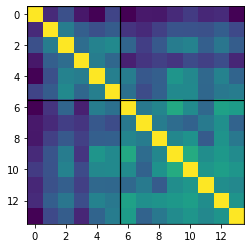

In [82]:
plot_breakpoints(vectorized_text, 1)

In [83]:
tf_vectorizer = TfidfVectorizer(analyzer="word", token_pattern = '[0-9]+[a-zAZ]*[.0-9]*[a-zAZ]*')
tf_vectorized_text = tf_vectorizer.fit_transform(line_str_I)

In [84]:
# Most distinctive glyphs of lines 0-5
tf_vectorizer.get_feature_names_out()[list(set(np.argmax(vectorized_text.toarray()[:6,:], axis=1)))]

array(['430', '600', '430.76', '76'], dtype=object)

In [85]:
# Most distinctive glyphs of lines 6-13
tf_vectorizer.get_feature_names_out()[list(set(np.argmax(vectorized_text.toarray()[6:,:], axis=1)))]

array(['90', '90.76', '11', '532', '71', '76'], dtype=object)

In [86]:
full_text = []
for line in encoded_lines_I:
    full_text.extend(line)

In [109]:
sel_glyphs = {}

for glyph in set(full_text):
    if '?' not in glyph and full_text.count(glyph) > 3:
        bounds = glyph_bound(glyph, encoded_lines_I)
        if bounds[1] < 6 or bounds[0] >= 6:
            sel_glyphs[glyph] = bounds

sel_glyphs_ordered = sorted(sel_glyphs.keys(), key=lambda x: sel_glyphs[x][0])

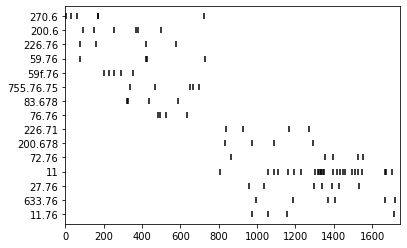

In [110]:
# Distribution of glyphs that appear exclusively
# in the first or second halves

plot_discourse(sel_glyphs_ordered, full_text)